<h1> Building a RAG Architecture </h1>

<p> In this notebook we use Ollama and a local docker image of Qdrant to connect a vector store to an LLM to set up RAG on news articles </p>

<h3> Imports </H3>

In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import logging
import sys
import llama_index

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))
llama_index.set_global_handler("simple")


<h3> EDA </h3>

In [2]:
files = glob.glob('../Cleaned Data/*.json')

df_list = []
for file in files:
    df = pd.read_json(file)
    df_list.append(df)
master_df = pd.concat(df_list)

In [3]:
master_df = master_df[~master_df['text'].str.strip().eq('')] # removing entries where there is no text 

In [4]:
from nltk.tokenize import word_tokenize

master_df['token_count'] = master_df['text'].apply(lambda x: len(word_tokenize(x)))


<p> Visualizing the amount of tokens in each news article </p>

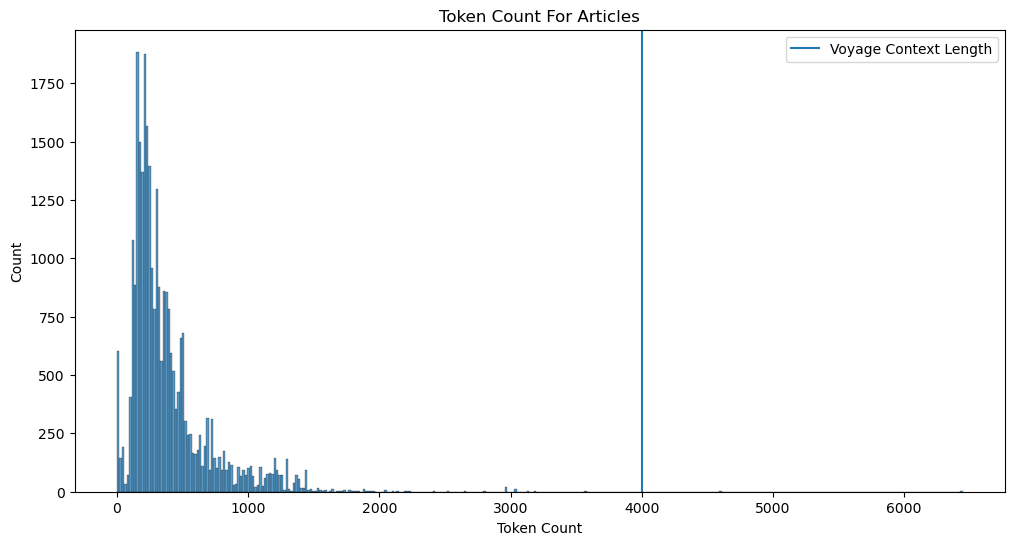

In [5]:
fig,ax = plt.subplots(1,1,figsize = (12,6))

sns.histplot(x = 'token_count', data = master_df, ax = ax)
ax.set_title("Token Count For Articles")
ax.set_xlabel("Token Count")
ax.axvline(x = 4000, label = 'Voyage Context Length')
ax.legend()

<h3> Prep Article Documents </h3>

In [6]:
from llama_index.schema import Document
import re

import re

def json_to_docs(data_list):
    doc_list = []
    i = 0
    for doc in data_list:
        text = doc['text'].strip()  # Ensure to remove leading/trailing whitespace
        if not text:  # If text is empty, skip this document
            continue
        
        text = re.sub(r" +", " ", text)
        doc.pop('text')
        meta_data = {key: str(value) for key, value in doc.items()}
        keys_to_delete = ['content', 'author_link', 'hashtag', 'image_url', 'length', 
                          'crawl_date', 'user-agent', 'source', 'article_summary', 'author']
        for key in keys_to_delete:
            if key in meta_data:
                del meta_data[key]
        for key, value in meta_data.items():
            meta_data[key] = re.sub(r" +", " ", value.strip())
        doc = Document(text=text, metadata=meta_data)
        doc_list.append(doc)
        i += 1

    return doc_list

In [8]:
file_examples = ['../Cleaned Data/Cleaned_Json_Final.json']


all_docs = []  # Initialize an empty list to hold all documents

for file_pwd in file_examples:
    with open(file_pwd, 'r') as file:
        record = json.load(file)
        docs = json_to_docs(record)
        all_docs.extend(docs)  # Extend the list with documents from the current file


<h3> Initialize LLM, Embedding Model, and Vector Store </h3>
<p> Using Ollama for the LLM, voyage api for the embedding model, and a local docker image of qdrant to host the vector store </p>

In [39]:
from llama_index.embeddings import VoyageEmbedding
import os
from qdrant_client import QdrantClient
from llama_index.llms import Ollama

model_name = "voyage-2"
voyage_api_key = os.environ.get("VOYAGE_API_KEY", "pa-sTJIK84MR4MS2ljOPbTnrriFosZ2YOholEAEzonqpPg")

embed_model = VoyageEmbedding(
    model_name=model_name, voyage_api_key=voyage_api_key, 
)

llm = Ollama(model="mistral", request_timeout=30.0)

client = QdrantClient("localhost", port=6333)

In [40]:
from llama_index import set_global_service_context
from llama_index import ServiceContext

service_context = ServiceContext.from_defaults(llm=llm, embed_model=embed_model
)

set_global_service_context(service_context)

<h3> Create Nodes from Chunks of Text Articles </h3>

In [41]:
from llama_index import Document
from llama_index.text_splitter import SentenceSplitter
from llama_index.extractors import TitleExtractor
from llama_index.ingestion import IngestionPipeline, IngestionCache

# create the pipeline with transformations
pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(chunk_size=1024, chunk_overlap=20)
    ]
)

# run the pipeline
nodes = pipeline.run(documents=all_docs)

In [42]:
print('Documents ', docs )
print("Nodes ", nodes)

Number of documents  [Document(id_='133c1e6b-18e7-45d2-8e07-f2fe8d4bd8cb', embedding=None, metadata={'website': 'www.deccanchronicle.com', 'section': 'Top Stories', 'sub_section': '', 'article_url': 'https://www.deccanchronicle.com/nation/politics/280321/tn-polls-battle-at-royapuram-is-a-matter-of-prestige-for-dmk-and-aiad.html', 'title': 'TN Polls: Battle at Royapuram is a matter of prestige for DMK and AIADMK', 'published_date': 'Mar 28, 2021, 12:41 pm IST', 'language': ''}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='The electoral battle for Royapuram, an arterial northern part of the city, has become very prestigious for the opposition DMK, which is desperately attempting to wrest back the seat it lost to AIADMK\'s D Jayakumar way back in 2001. Elections to 234 Assembly seats in Tamil Nadu will be held on April 6, with counting to be taken up on May 2. \xa0 Jayakumar, senior AIADMK leader and state fisheries minister, has bulldozed candid

In [43]:
len(nodes)

288

<h3> Creating the vector store </h3>

In [44]:
from llama_index import VectorStoreIndex
from llama_index.storage.storage_context import StorageContext
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index import VectorStoreIndex

vector_store = QdrantVectorStore(client=client, collection_name="Naive_RAG")
storage_context = StorageContext.from_defaults(vector_store=vector_store) # connect llamaindex with qdrant
index = VectorStoreIndex(
    nodes, storage_context=storage_context, service_context=service_context
)

<h3> Testing Retrieval </h3> 

In [45]:
from IPython.display import display, HTML

def visualize_retrieved_nodes(nodes):
    result_dicts = []
    for node in nodes:
        node_text = node.node.get_text()
        #node_text = node_text.replace("\n", " ")
        website = node.node.metadata['website']
        section = node.node.metadata['section']
        sub_section = node.node.metadata['sub_section']
        title = node.node.metadata['title']
        publish_date= node.node.metadata['published_date']

        result_dict = {"Score": node.score,'title':title, "Text": node_text,'Publish Date':publish_date,'Website':website,'Section':section,'Sub Section':sub_section}
        result_dicts.append(result_dict)

    df = pd.DataFrame(result_dicts)
    display(HTML(df.to_html().replace("\\n", "<br>")))




In [46]:
from llama_index.retrievers import VectorIndexRetriever
from llama_index.response_synthesizers import get_response_synthesizer
from llama_index.query_engine.retriever_query_engine import RetrieverQueryEngine
from llama_index.response.pprint_utils import pprint_response
from pprint import pprint



retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=3,
)

retrievals = retriever.retrieve(
    "Who was the fastest to administer covid vaccines?"
)

visualize_retrieved_nodes(retrievals)

,Score,title,Text,Publish Date,Website,Section,Sub Section
0,0.823411,India fastest to administer 100 million COVID vaccine doses,"India has become the fastest country to administer 100 million coronavirus vaccine doses as per numbers with India's Ministry of Health and Family Welfare. To administer 100 million COVID vaccine doses, India took just 85 days. This is a major feat as the US and China took 89 and 102 days respectively to reach the 100 million mark. The development is sure to give a further boost to India's fight against the coronavirus pandemic even as a spike in number of infections has been seen in recent days. A country of more than a billion people, India faces a big task as it vaccinates its population. Frontline workers, citizens aged 60 and above as well as those aged 45 years and above (with comorbidities) have been given preference in the initial stages of India's coronavirus vaccination drive. The need for redoubled efforts in the fight against the pandemic was felt on Saturday as more than 100 thousand new coronavirus cases were reported across India. The death toll was up too. As per the health ministry data, death toll rose by 794 to a total of 168,436. Most cases have been detected in the western state of Maharashtra. The state has already shut down restaurants, malls and places of worship and barred the movement of most people to control the outbreak that has threatened to overrun medical facilities and created vaccine shortages. The weekend lockdown will end on Monday.",New Delhi,www.wionews.com,WORLD,Central Asia
1,0.777751,COVID-19 vaccine shortages hit poorer countries after India stops exporting jabs from Serum Institute,"As many as 60 countries might be stalled at the first shots of their vaccinations because nearly all deliveries through the global programme are blocked until as late as June. The COVAX initiative is designed to provide vaccines to countries lacking the clout to negotiate on their own for scarce supplies. In the past two weeks, only 2 million doses were cleared for shipment to 92 countries through the program, the same amount injected in Britain alone. Internal World Health Organization documents obtained by say uncertain deliveries are causing some countries to lose faith in COVAX. The vaccine shortage stems mostly from India's decision to stop exporting vaccines from its Serum Institute factory because of a surge of cases in that country. The factory produces the majority of the AstraZeneca doses that COVAX counted on to supply about a third of the global population. WHO Director General Tedros Adhanom Ghebreysus says while one in four people in rich countries had received a vaccine, only one in 500 people in poorer countries had received a dose.",None,www.firstpost.com,health,


<h3> Adding the LLM and Viewing RAG Outputs </h3>

In [47]:

from llama_index.response_synthesizers import get_response_synthesizer
from llama_index.query_engine.retriever_query_engine import RetrieverQueryEngine


# configure response synthesizer
response_synthesizer = get_response_synthesizer()

# assemble query engine
query_engine = RetrieverQueryEngine(
    retriever=retriever,
    response_synthesizer=response_synthesizer,
)


response = query_engine.query("What's going on with biden and batteries?")
print(response)

 Recently, South Korean battery makers LG Chem and SK Innovation agreed to settle a long-standing trade secrets dispute that had posed a threat to a key Georgia plant producing batteries for electric vehicles (EVs) from Ford Motor and Volkswagen. The Biden administration faced a deadline to reverse a US International Trade Commission decision, but the settlement is expected to be announced soon and will reportedly involve financial reparations to LG Chem. This resolution is seen as a win for President Biden, who has made boosting EVs and US battery production a priority in his administration's plans. The global auto industry is rapidly moving towards developing EVs, and the US aims to invest $174 billion to increase sales and expand charging infrastructure.


<h3> Creating Evaluation Questions </h3>

In [48]:
import nest_asyncio

nest_asyncio.apply()

from llama_index.evaluation import DatasetGenerator
data_generator = DatasetGenerator(nodes)
eval_questions = data_generator.generate_questions_from_nodes()

# adding a save file as generating questions takes a long time
pd.DataFrame({'Questions':eval_questions}).to_csv('Evaluation_Questions_RAG.csv',index = False)




<p> Creating a a file for 100 randomly sampled questions. The initial volume of questions required too much compute. </p>

In [ ]:
eval_q = pd.read_csv('Evaluation_Questions_RAG.csv')['Questions'].to_list()

import random
sampled_questions = random.sample(eval_q,100)

pd.DataFrame({'SampleQuestions':sampled_questions}).to_csv('Sampled_Questions.csv') 


<h3> Adding an updated article to the vector store </h3>
<p> Articles were scraped as of 2021 so need to test on recent news </p>

In [54]:
website = "www.cnbc.com"
section = 'Tech'
sub_section = ""
article_url = 'https://www.cnbc.com/2024/02/22/nvidia-shares-pop-12percent-in-premarket-trade-after-ai-fueled-bumper-earnings-.html'
title = "Nvidia shares pop 15% after AI-fueled bumper earnings"
author = "Arjun Kharpal"
author_link = ""
published_date = "2024-02-22"
article_summary = ""
text = """Nvidia shares jumped 15% on Thursday morning, a day after the chip giant posted bumper earnings that beat Wall Street estimates.

The U.S. tech giant reported revenue of $22.10 billion for its fiscal fourth quarter, a rise of 265% year on year, while net income surged by 769%, as the company continues to see a boost from excitement over artificial intelligence.

Nvidia chips are used to train the huge AI models such as those developed by Microsoft and Meta.

Nvidia sees no signs of slowing. The company forecast its revenue in the current quarter will hit $24 billion, way ahead of estimates.

“Fundamentally, the conditions are excellent for continued growth” in 2025 and beyond, Nvidia CEO Jensen Huang told analysts on Wednesday, adding to the bullish sentiment around the stock.

Nvidia’s Data Center business, which includes the company’s H100 graphics cards that are used for AI training, posted sales of $18.4 billion in the fourth quarter, representing 409% year-on-year growth. The positive outlook from Nvidia prompted a round of broker upgrades Thursday. JPMorgan raised its price target on Nvidia’s stock from $650 to $850, while Bank of America Global Research hiked its target from $800 to $925.

Nvidia’s stock closed at $674.72 on Thursday. The shares were under pressure ahead of the earnings report as traders took profit and investors were concerned that Nvidia might not be able to hit lofty expectations.

But its market-beating numbers dispelled those fears and also pulled other global chip stocks higher."""

image_url = "" 
crawl_date = "2024-02-22"
user_agent = "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/22.0.1207.1 Safari/537.1"
content = "text/html; charset=UTF-8"
language = ""
length = "" 
source = "scrapy"

In [9]:
nvidia_path = '../Cleaned Data/Nvidia_Example.json'
with open(nvidia_path, 'r') as file:
    record = json.load(file)
    docs = json_to_docs(record)

In [61]:
new_node = pipeline.run(documents=docs)

In [64]:
index.insert_nodes(new_node) # insert into vector store